<a href="https://colab.research.google.com/github/diegulio/Breed_Recognition-to-Buscomiperro/blob/main/BMP_UpdateModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Updates 
Hasta el momento, ya tenemos un modelo con metricas decentes, el cual demostró tener buenos resultados, aún así, antes de pasar el modelo a producción y desplegarlo en alguna web, quiero agregar algunas razas (clases) comunes en Chile y además aprovechar de poner en práctica algunas nuevas prácticas (valga la redundancia) que he aprendido, aparte de intentar mejorar con una nueva arquitectura las métricas obtenidas hasta el momento. Sin más preambulo, lo que haremos será:



1.   Agregar razas nuevas: `Dalmata-Akita-Bulldog Inglés` 
2.   Probar nuevos modelos pre entrenados [State of the Art](https://paperswithcode.com/task/image-classification) en [keras](https://keras.io/api/applications/) (Elegir los mejores 3) `feature extraction`, de acá se obtiene: `modelo_1, modelo_2 y modelo_3` 
3.   Fine-tuning modelos 1,2 y 3 `modelo_4, modelo_5 y modelo_6`
4.   Hacer un ensemble de los modelos pre entrenados escogidos `modelo_7` 
5.   Añadir en el Top una red neuronal luego del ensemble `modelo_8`
6.   Agregar Data Augmentation en el mejor modelo (Data Augmentation dentro del modelo) `modelo_9`



Recordar: Utilizar nuevos callbacks aprendidos




# Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing

# Helper Functions

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  


# Convierte una carpeta en formato zip, esto para que pueda ser descargada en google colab
def zip_folder(folder_dir):
  import shutil
  shutil.make_archive(folder_dir, 'zip', folder_dir)

# Callbacks

In [ ]:
import datetime
import os

def create_tensorboard_callback(dir_name, experiment_name):
  # Si no esta el directorio dir_name creado, lo creamos
  if dir_name not in os.listdir():
    os.mkdir(dir_name)

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Data Directories

In [ ]:
model_image_size_map = {
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}


In [ ]:
# Ahora se encuentran las razas agregadas
train_dir = '/content/drive/MyDrive/Colab Data/Proyecto buscomiperro/train'
test_dir = '/content/drive/MyDrive/Colab Data/Proyecto buscomiperro/test'


# Diferencias TF hub vs Keras Applications

Si bien trabajan sobre los mismos modelos pre entrenados, hay grandes diferencias en cuanto a las condiciones de entrada (Shape) y sus respectivas salidas. Estas son algunas diferencias: <br>
- TF Hub version returns logits (before the softmax function that turns them into probabilities), which is a common practice, because the cross-entropy loss can be computed with greater numerical stability from the logits.
- The TF Hub model assumes float32 inputs in the range of [0,1], which is what you get from tf.image.decode_jpeg(...) followed by tf.image.convert_image_dtype(..., tf.float32). The Keras code uses a model-specific range (likely [-1,+1]).
- The TF Hub model reflects the original SLIM checkpoint more completely in returning all its 1001 output classes. As stated in the ImageNetLabels.txt linked from the documentation, the added class 0 is "background" (aka. "stuff"). That is what object detection uses to indicate image background as opposed to an object of any known class.

Fuente : https://stackoverflow.com/questions/60251715/difference-between-keras-and-tensorflow-hub-version-of-mobilenetv2

# Pretrained Models
Cargamos los modelos pre entrenados usando la API de Keras o Tensorflow Hub. <br>
Hay que tener mucho ojo en el preprocesamiento de las imagenes para cada modelo pre entrenado

In [ ]:
# Vamos a crear una función para poder definir cada modelo pre entrenado
def create_model(model_url, img_size, scale = True, trainable = False):

  # Data augmentation / Scaling
  data_augmentation = tf.keras.Sequential([
                                        #preprocessing.RandomFlip("horizontal"),
                                        #preprocessing.RandomRotation(0.2),
                                        #preprocessing.RandomZoom(0.2),
                                        #preprocessing.RandomHeight(0.2),
                                        #preprocessing.RandomWidth(0.2),
                                        preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
                                        ], name ="data_augmentation")






  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable= trainable ,
                                           name='feature_extraction_layer',
                                           input_shape= img_size+(3,)) # define the input image shape

  model = tf.keras.Sequential([
    layers.InputLayer(input_shape= img_size + (3,)),
    data_augmentation,
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
def create_model_application(model_application, preprocess_input, img_size, model_name = 'Model'):
  from tensorflow.keras.utils import plot_model

  base_model = model_application(include_top = False)
  base_model.trainable = False

  plot_model(base_model, to_file = model_name + '_plot.png')

  # Arquitectura

  inputs = tf.keras.layers.Input(img_size + (3,), name = 'Input_Layer')

  x = preprocess_input(inputs)

  x = base_model(x, training = False) # se me olvido poner trainable = False D: no me la container amarillo

  x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_layer')(x)

  outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name = 'Output_Layer')(x)

  model = tf.keras.Model(inputs, outputs, name = model_name)

  model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
  
  return model








## InceptionV3 - TF hub

| Model       | Size  | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth |
|-------------|-------|----------------|----------------|------------|-------|
| InceptionV3 | 92 MB | 0.779          | 0.937          | 23,851,784 | 159   |

Debido a que esta fue la arquitectura que probamos anteriormente, comenzaremos con InceptionV3, viendo en TF Hub me di cuenta que existian ademas pesos pre entrenados con un dataset llamado iNaturalist, y ya que nuestro proyecto se enfoca a animales, probaré también estos pesos para ver que tal.


*   [Inception V3- ImageNet](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5)
*   [Inception V3- iNaturalist](https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5)


**Input Shape Requeriments** <br>
The output is a batch of feature vectors. For each input image, the feature vector has size num_features = 2048. The feature vectors can then be used further, e.g., for classification as above.

The input images are expected to have color values in the range [0,1], following the common image input conventions. The expected size of the input images is **height x width = 299 x 299** pixels by default, but other input sizes are possible (within limits).




In [ ]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_CLASSES = 125 # Las 122 anteriores + las 3 nuevas.

125 clases ya que se agregaron 3 más

DATA

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE
                                                                 )
  
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE
                                                                )
  

Found 8594 files belonging to 125 classes.
Found 2108 files belonging to 125 classes.


In [ ]:
# Feature vectors of images with Inception V3 trained on ImageNet (ILSVRC-2012-CLS).
url_IncImgNet = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5'

# Feature vectors of images with Inception V3 trained on the iNaturalist (iNat) 2017 dataset.
url_IncNaturalist = 'https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5'

### ImageNet

In [ ]:
IncImgNet_model = create_model(url_IncImgNet , IMG_SIZE, scale = True) # Inception necesita las imagenes en un rango entre [0,1]

In [ ]:
IncImgNet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 299, 299, 3)       0         
_________________________________________________________________
feature_extraction_layer (Ke (None, 2048)              21802784  
_________________________________________________________________
output_layer (Dense)         (None, 125)               256125    
Total params: 22,058,909
Trainable params: 256,125
Non-trainable params: 21,802,784
_________________________________________________________________


Es importante entender los shape de estas etapas, según la documentación, de InceptionV3 sale (luego del respectivo Flatten) un vector de tamaño 2048. Luego viene un Dense layer de 125 nodos con función de activación Softmax ya que tenemos 125 clases. Es por esto que los 2048 estan conectados a los 125 nodos de la última layer, además cada nodo tiene un parámetro de Bias, resultando en:

\begin{equation}
parametros = 2048*125 + 125 = 256125
\end{equation}

In [ ]:
# Compilamos
IncImgNet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
IncImgNet_history = IncImgNet_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        # Add TensorBoard callback to model (callbacks parameter takes a list)
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                              experiment_name="InceptionV3-ImageNet")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/InceptionV3-ImageNet/20210526-193507
Epoch 1/5
269/269 [==============================] - 1268s 4s/step - loss: 1.1313 - accuracy: 0.7767 - val_loss: 0.4360 - val_accuracy: 0.8743
Epoch 2/5
269/269 [==============================] - 72s 265ms/step - loss: 0.2790 - accuracy: 0.9181 - val_loss: 0.3922 - val_accuracy: 0.8757
Epoch 3/5
269/269 [==============================] - 72s 265ms/step - loss: 0.1908 - accuracy: 0.9446 - val_loss: 0.3795 - val_accuracy: 0.8824
Epoch 4/5
269/269 [==============================] - 72s 264ms/step - loss: 0.1413 - accuracy: 0.9607 - val_loss: 0.3779 - val_accuracy: 0.8771
Epoch 5/5
269/269 [==============================] - 72s 265ms/step - loss: 0.1103 - accuracy: 0.9716 - val_loss: 0.3687 - val_accuracy: 0.8781


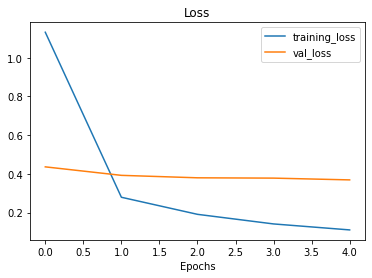

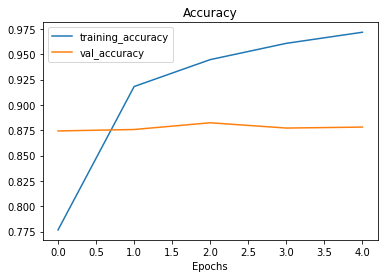

In [ ]:
plot_loss_curves(IncImgNet_history)

In [ ]:
IncImgNet_model.save('IncImgNet.h5')

### iNaturalist

In [ ]:
IncNaturalist_model = create_model(url_IncNaturalist, IMG_SIZE, scale = True, trainable = False)

In [ ]:
IncNaturalist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 299, 299, 3)       0         
_________________________________________________________________
feature_extraction_layer (Ke (None, 2048)              21802784  
_________________________________________________________________
output_layer (Dense)         (None, 125)               256125    
Total params: 22,058,909
Trainable params: 256,125
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
IncNaturalist_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
IncNaturalist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 299, 299, 3)       0         
_________________________________________________________________
feature_extraction_layer (Ke (None, 2048)              21802784  
_________________________________________________________________
output_layer (Dense)         (None, 125)               256125    
Total params: 22,058,909
Trainable params: 256,125
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Fit the model
IncNaturalist_history = IncNaturalist_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        # Add TensorBoard callback to model (callbacks parameter takes a list)
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                              experiment_name="InceptionV3-iNaturalist")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/InceptionV3-iNaturalist/20210527-043754
Epoch 1/5
269/269 [==============================] - 73s 271ms/step - loss: 0.9931 - accuracy: 0.7647 - val_loss: 2.0648 - val_accuracy: 0.4540
Epoch 2/5
269/269 [==============================] - 72s 266ms/step - loss: 0.8584 - accuracy: 0.8093 - val_loss: 2.0329 - val_accuracy: 0.4711
Epoch 3/5
269/269 [==============================] - 72s 267ms/step - loss: 0.7452 - accuracy: 0.8414 - val_loss: 2.0623 - val_accuracy: 0.4639
Epoch 4/5
269/269 [==============================] - 72s 265ms/step - loss: 0.6546 - accuracy: 0.8671 - val_loss: 2.0757 - val_accuracy: 0.4696
Epoch 5/5
269/269 [==============================] - 72s 266ms/step - loss: 0.5749 - accuracy: 0.8949 - val_loss: 2.0794 - val_accuracy: 0.4720


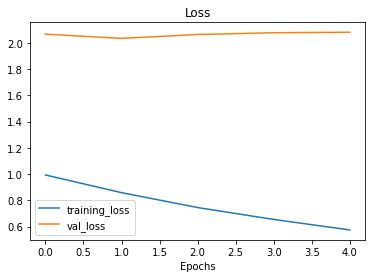

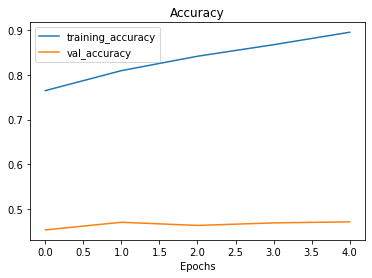

In [ ]:
plot_loss_curves(IncNaturalist_history)

### Conclusión 
En base a los resultados obtenidos, podemos definir el `modelo 1 = IncImgNet`.

## InceptionV3 - Keras Applications

Este proceso solo lo hago con fines de aprendizaje, ya que no deberian variar mucho los resultados, pero creo que es bueno poder prácticar ambas herramientas. <br>
De todas formas, una diferencia inmediata que pude encontrar es que utilizando la API de Keras, podemos obtener el preprocesamiento para cada modelo pre entrenado. <br>
Incluso dentro de este enfoque, hay otros 2 enfoques distintos, Sequential API vs Functional API. En el pasado trabajamos con el enfoque Secuencial. La principal diferencia entre estas APIS es que la API funcional es más flexible que la secuencial, ya que esta ultima te permite crear modelos layer por layer, y **no** permite: Share Layers, Tener branches, Multiples entradas ni multiple salidas. En cambio con la API funcional si se puede. [Más Info](https://hanifi.medium.com/sequential-api-vs-functional-api-model-in-keras-266823d7cd5e). 
Por razones de estudio, utilizaré la api funcional.

**Input Shape Requeriments**
Es importante destacar que, si bien en TF Hub se esperaba un rango de entrada de [0,1], en Keras Applications se espera que sea `[-1,1]`. Esto es una gran diferencia, pero para esto nos sirve la función `preprocess_input` que cada modelo pre entrenado tiene consigo. Los pixeles se mantienen, siendo estos `299x299`

In [ ]:
from tensorflow.keras.applications import InceptionV3

# modelo pre entrenado
base_model = InceptionV3(include_top = False, input_shape= IMG_SIZE + (3,)) # Pondremos nuestro propio Top Layer (Dense(125))

# Congelamos el modelo para mantener los patrones pre entrenados
base_model.trainable = False


96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# Veamos la impresionante arquitectura de este modelo
from tensorflow.keras.utils import plot_model
plot_model(base_model, show_shapes = True)

SHEEEEEEESH

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input # Preprocesa las imaganes a lo que acomoda el modelo pre entrenado

# Definimos la Arquitectura con la API Funcional

inputs = tf.keras.layers.Input(IMG_SIZE + (3,), name = 'Input_Layer') # Debe haber un input layer ya que el enfoque funcional lo requiere

x = preprocess_input(inputs)

x = base_model(x) 

# A diferencia de Tensorflow HUB, la salida del modelo base no es plana, para poder hacerla plana, una opción es aplicar un Average Pool,
# esto tambien se hace en el Top por Defecto de Inception (para comprobarlo puedes cargar el modelo base con include_top = True y echar un vistazo 
# a los ultimos layers)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)



outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name = 'Output_layer')(x)



IncKA_model = tf.keras.Model(inputs, outputs) # Se construye el modelo





In [ ]:
IncKA_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling_layer (None, 2048)              0         
_________________________________________________________________
Output_layer (Dense)         (None, 125)               256125    
Total params: 22,058,909
Trainable params: 256,125
Non-trainable params: 21,802,784
_________________________________________

Veamos que los parametros son exactamente igual a los que teniamos anteriormente

In [ ]:
# Compilamos
IncKA_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fit 
IncKA_history = IncKA_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                # Add TensorBoard callback to model (callbacks parameter takes a list)
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                      experiment_name="InceptionV3-FunctionalAPI")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/InceptionV3-FunctionalAPI/20210527-215004
Epoch 1/5
269/269 [==============================] - 2007s 7s/step - loss: 1.1663 - accuracy: 0.7704 - val_loss: 0.4418 - val_accuracy: 0.8695
Epoch 2/5
269/269 [==============================] - 74s 273ms/step - loss: 0.2858 - accuracy: 0.9149 - val_loss: 0.3935 - val_accuracy: 0.8748
Epoch 3/5
269/269 [==============================] - 74s 272ms/step - loss: 0.1961 - accuracy: 0.9440 - val_loss: 0.3923 - val_accuracy: 0.8809
Epoch 4/5
269/269 [==============================] - 74s 272ms/step - loss: 0.1440 - accuracy: 0.9601 - val_loss: 0.3767 - val_accuracy: 0.8743
Epoch 5/5
269/269 [==============================] - 74s 272ms/step - loss: 0.1101 - accuracy: 0.9716 - val_loss: 0.3670 - val_accuracy: 0.8876


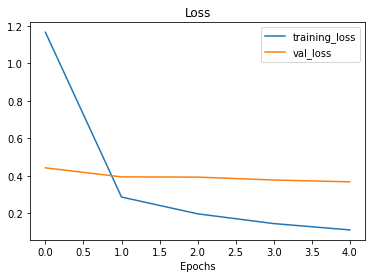

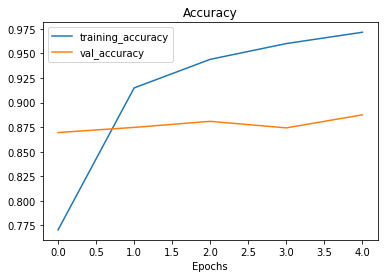

In [ ]:
plot_loss_curves(IncKA_history)

Resultados bastantes similares, yo creo que la diferencia radica en la aleatoridad inicial de los pesos de las Top Layers.

In [ ]:
IncKA_model.save('IncImgNet-FunAPI.h5')

## Xception

| Model    | Size  | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth |
|----------|-------|----------------|----------------|------------|-------|
| Xception | 88 MB | 0.790          | 0.945          | 22,910,480 | 126   |

> TFhub no tiene la aquitectura Xception incorporada, por lo que recurriremos a la APi de Keras

https://keras.io/api/applications/xception/


In [ ]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_CLASSES = 125 # Las 122 anteriores + las 3 nuevas.

DATA

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE
                                                                 )
  
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE
                                                                )
  

Found 8594 files belonging to 125 classes.
Found 2108 files belonging to 125 classes.


### Xception - Keras Applications

**Input Shape Requeriments**
- 299x299
- range [-1,1] (`preprocess_input`)

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

Xception_model = create_model_application(Xception, preprocess_input, IMG_SIZE)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
Xception_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_layer (Global (None, 2048)              0         
_________________________________________________________________
Output_Layer (Dense)         (None, 125)               256125    
Total params: 21,117,605
Trainable params: 256,125
Non-trainable params: 20,861,480
___________________________________________

In [ ]:
# Fit 
Xception_history = Xception_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                # Add TensorBoard callback to model (callbacks parameter takes a list)
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                      experiment_name="Xception")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/Xception/20210528-165207
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


269/269 [==============================] - 2073s 7s/step - loss: 1.1696 - accuracy: 0.7974 - val_loss: 0.4182 - val_accuracy: 0.8971
Epoch 2/5
269/269 [==============================] - 122s 452ms/step - loss: 0.2905 - accuracy: 0.9246 - val_loss: 0.3509 - val_accuracy: 0.8999
Epoch 3/5
269/269 [==============================] - 123s 454ms/step - loss: 0.2143 - accuracy: 0.9416 - val_loss: 0.3342 - val_accuracy: 0.9004
Epoch 4/5
269/269 [==============================] - 122s 453ms/step - loss: 0.1697 - accuracy: 0.9543 - val_loss: 0.3281 - val_accuracy: 0.8980
Epoch 5/5
269/269 [==============================] - 122s 453ms/step - loss: 0.1402 - accuracy: 0.9629 - val_loss: 0.3208 - val_accuracy: 0.9004


Aparentemente tiene mejores resultados ($\approx +3\%$) que InceptionV3

In [ ]:
Xception_model.evaluate(test_data)

66/66 [==============================] - 23s 335ms/step - loss: 0.3208 - accuracy: 0.9004


[0.3207794427871704, 0.900379478931427]

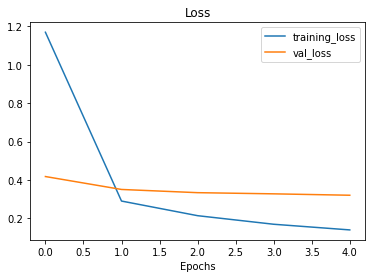

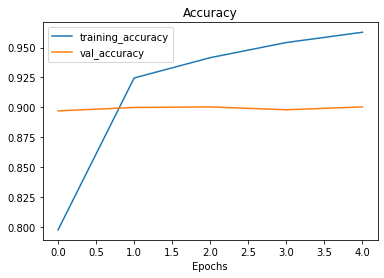

In [ ]:
plot_loss_curves(Xception_history)

In [ ]:
Xception_model.save('Xception.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
zip_folder('tensorflow_hub')

## ResNet152V2

| Model       | Size   | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth |
|-------------|--------|----------------|----------------|------------|-------|
| ResNet152V2 | 232 MB | 0.780          | 0.942          | 60,380,648 |       |



In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 125 # Las 122 anteriores + las 3 nuevas.

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE
                                                                 )
  
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE
                                                                )

Found 8594 files belonging to 125 classes.
Found 2108 files belonging to 125 classes.


### TF HUB

**Shape Requeriments**
The input images are expected to have color values in the range `[0,1]`, following the common image input conventions. The expected size of the input images is height x width = `224 x 224` pixels by default, but other input sizes are possible (within limits).

https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5

In [ ]:
url_resnet = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5'

In [ ]:
resnet_hub_model = create_model(url_resnet, IMG_SIZE, scale = True, trainable = False)

In [ ]:
resnet_hub_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
feature_extraction_layer (Ke (None, 2048)              58331648  
_________________________________________________________________
output_layer (Dense)         (None, 125)               256125    
Total params: 58,587,773
Trainable params: 256,125
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
# Compilamos
resnet_hub_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_hub_history = resnet_hub_model.fit(train_data,
                                          epochs=5,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=len(test_data),
                                          # Add TensorBoard callback to model (callbacks parameter takes a list)
                                          callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                                experiment_name="resnet_hub")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet_hub/20210529-042304
Epoch 1/5
269/269 [==============================] - 1280s 5s/step - loss: 1.4942 - accuracy: 0.6397 - val_loss: 0.8287 - val_accuracy: 0.7652
Epoch 2/5
269/269 [==============================] - 99s 367ms/step - loss: 0.4356 - accuracy: 0.8684 - val_loss: 0.8413 - val_accuracy: 0.7623
Epoch 3/5
269/269 [==============================] - 98s 364ms/step - loss: 0.2267 - accuracy: 0.9405 - val_loss: 0.8091 - val_accuracy: 0.7690
Epoch 4/5
269/269 [==============================] - 98s 363ms/step - loss: 0.1292 - accuracy: 0.9720 - val_loss: 0.8343 - val_accuracy: 0.7694
Epoch 5/5
269/269 [==============================] - 98s 363ms/step - loss: 0.0826 - accuracy: 0.9862 - val_loss: 0.8382 - val_accuracy: 0.7676


In [ ]:
zip_folder('tensorflow_hub')

### Keras Application

https://keras.io/api/applications/resnet/#resnet152v2-function

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

base_model = ResNet152V2

resnet_ka_model = create_model_application(base_model, preprocess_input, IMG_SIZE, model_name = 'resnet')

234553344/234545216 [==============================] - 3s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.604814 to fit



In [ ]:
resnet_ka_model.summary()

Model: "resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, None, None, 2048)  58331648  
_________________________________________________________________
global_average_layer (Global (None, 2048)              0         
_________________________________________________________________
Output_Layer (Dense)         (None, 125)               256125    
Total params: 58,587,773
Trainable params: 256,125
Non-trainable params: 58,331,648
__________________________________________

In [ ]:
# Fit 
resnet_ka_history = resnet_ka_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                # Add TensorBoard callback to model (callbacks parameter takes a list)
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                      experiment_name="resnet_KA")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet_KA/20210529-143027


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
269/269 [==============================] - 1297s 5s/step - loss: 1.5197 - accuracy: 0.6317 - val_loss: 0.8952 - val_accuracy: 0.7410
Epoch 2/5
269/269 [==============================] - 100s 369ms/step - loss: 0.4386 - accuracy: 0.8663 - val_loss: 0.8493 - val_accuracy: 0.7595
Epoch 3/5
269/269 [==============================] - 101s 374ms/step - loss: 0.2328 - accuracy: 0.9360 - val_loss: 0.8525 - val_accuracy: 0.7576
Epoch 4/5
269/269 [==============================] - 101s 374ms/step - loss: 0.1328 - accuracy: 0.9713 - val_loss: 0.8550 - val_accuracy: 0.7704
Epoch 5/5
269/269 [==============================] - 102s 379ms/step - loss: 0.0825 - accuracy: 0.9869 - val_loss: 0.8418 - val_accuracy: 0.7728


Vemos que Resnet consigue unos resultados buenos, pero no tanto como los otros estimadores, aún asi, ya que queremos escoger 3 modelos, este quedaria seleccionado.

In [ ]:
resnet_ka_model.evaluate(test_data)

66/66 [==============================] - 20s 298ms/step - loss: 0.8418 - accuracy: 0.7728


[0.8417608737945557, 0.7727704048156738]

In [ ]:
zip_folder('tensorflow_hub')

## EfficientNet

### EfficientNet 7

| Model          | Size   | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth |
|----------------|--------|----------------|----------------|------------|-------|
| EfficientNetB7 | 256 MB | -              | -              | 66,658,687 | -     |


In [ ]:
IMG_SIZE = (600,600)
NUM_CLASSES = 125
BATCH_SIZE = 32

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE
                                                                 )
  
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE
                                                                )

Found 8594 files belonging to 125 classes.
Found 2108 files belonging to 125 classes.


**Tensor Hub**

> For this module, the size of the input image is flexible, but it would be best to match the model training input, which is height x width = 600 x 600 pixels for this model. The input images are expected to have color values in the range [0,1], following the common image input conventions.

Fine-tuning

https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1

In [ ]:
url_EfficientNet7 = 'https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1'

In [ ]:
EfficientNet7_hub_model = create_model(url_EfficientNet7, IMG_SIZE, scale = True, trainable = False)

In [ ]:
EfficientNet7_hub_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 600, 600, 3)       0         
_________________________________________________________________
feature_extraction_layer (Ke (None, 2560)              64097680  
_________________________________________________________________
output_layer (Dense)         (None, 125)               320125    
Total params: 64,417,805
Trainable params: 320,125
Non-trainable params: 64,097,680
_________________________________________________________________


In [ ]:
# Compilamos
EfficientNet7_hub_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
EfficientNet7_hub_history = EfficientNet7_hub_model.fit(train_data,
                                          epochs=5,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=len(test_data),
                                          # Add TensorBoard callback to model (callbacks parameter takes a list)
                                          callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                                experiment_name="EfficientNet7_hub")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/EfficientNet7_hub/20210530-032803
Epoch 1/5
269/269 [==============================] - 2808s 10s/step - loss: 1.0858 - accuracy: 0.8593 - val_loss: 0.2259 - val_accuracy: 0.9492
Epoch 2/5
269/269 [==============================] - 927s 3s/step - loss: 0.1640 - accuracy: 0.9632 - val_loss: 0.1720 - val_accuracy: 0.9535
Epoch 3/5
269/269 [==============================] - 927s 3s/step - loss: 0.1111 - accuracy: 0.9737 - val_loss: 0.1613 - val_accuracy: 0.9554
Epoch 4/5
269/269 [==============================] - 927s 3s/step - loss: 0.0833 - accuracy: 0.9800 - val_loss: 0.1584 - val_accuracy: 0.9549
Epoch 5/5
269/269 [==============================] - 927s 3s/step - loss: 0.0657 - accuracy: 0.9831 - val_loss: 0.1558 - val_accuracy: 0.9568


In [ ]:
EfficientNet7_hub_model.evaluate(test_data)

66/66 [==============================] - 183s 3s/step - loss: 0.1558 - accuracy: 0.9568


[0.15576839447021484, 0.9568310976028442]

In [ ]:
EfficientNet7_hub_model.save('EfficientNet7_hub.h5')

In [ ]:
zip_folder('tensorflow_hub')

El mejor resultado hasta el momento!!

**Keras Applications**

https://keras.io/api/applications/efficientnet/#efficientnetb7-function

> For EfficientNet, input preprocessing is included as part of the model (as a Rescaling layer), and thus tf.keras.applications.efficientnet.preprocess_input is actually a pass-through function. EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range.

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

EfficientNet7_ka_model = create_model_application(EfficientNetB7, preprocess_input, IMG_SIZE, model_name = 'EfficientNet7')

258080768/258076736 [==============================] - 2s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.414274 to fit



In [ ]:
EfficientNet7_ka_model.summary()

Model: "EfficientNet7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 600, 600, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_layer (Global (None, 2560)              0         
_________________________________________________________________
Output_Layer (Dense)         (None, 125)               320125    
Total params: 64,417,812
Trainable params: 320,125
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
# Fit 
EfficientNet7_ka_history = EfficientNet7_ka_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                # Add TensorBoard callback to model (callbacks parameter takes a list)
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                      experiment_name="EfficientNet_KA")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/EfficientNet_KA/20210530-183201


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
269/269 [==============================] - 2111s 8s/step - loss: 1.1452 - accuracy: 0.8480 - val_loss: 0.2516 - val_accuracy: 0.9407
Epoch 2/5
269/269 [==============================] - 952s 4s/step - loss: 0.1995 - accuracy: 0.9547 - val_loss: 0.1883 - val_accuracy: 0.9483
Epoch 3/5
269/269 [==============================] - 951s 4s/step - loss: 0.1407 - accuracy: 0.9637 - val_loss: 0.1737 - val_accuracy: 0.9492
Epoch 4/5
269/269 [==============================] - 951s 4s/step - loss: 0.1095 - accuracy: 0.9724 - val_loss: 0.1681 - val_accuracy: 0.9521
Epoch 5/5
269/269 [==============================] - 952s 4s/step - loss: 0.0896 - accuracy: 0.9761 - val_loss: 0.1649 - val_accuracy: 0.9554


In [ ]:
EfficientNet7_ka_model.evaluate(test_data)

66/66 [==============================] - 185s 3s/step - loss: 0.1649 - accuracy: 0.9554


[0.16494086384773254, 0.955407977104187]

In [ ]:
EfficientNet7_ka_model.save('EfficientNet7_ka.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
zip_folder('/content/tensorflow_hub')

## InceptionResNetV2

> Desde ahora solo ocupare un enfoque (TFHUB o Applications)

| Model             | Size   | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth |
|-------------------|--------|----------------|----------------|------------|-------|
| InceptionResNetV2 | 215 MB | 0.803          | 0.953          | 55,873,736 | 572   |


**Shape Requeriments**

- `img_dim = 299x299`
- `range_pixel = [-1,1]`

Data

In [ ]:
IMG_SIZE = (299,299)
NUM_CLASSES = 125
BATCH_SIZE = 32

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE
                                                                 )
  
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE
                                                                )

Found 8594 files belonging to 125 classes.
Found 2108 files belonging to 125 classes.


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

InceptionResNetV2_model = create_model_application(InceptionResNetV2, preprocess_input, IMG_SIZE, model_name = 'InceptionResNetV2')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.591003 to fit



In [ ]:
InceptionResNetV2_model.summary()

Model: "InceptionResNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
global_average_layer (Global (None, 1536)              0         
_________________________________________________________________
Output_Layer (Dense)         (None, 125)               192125    
Total params: 54,528,861
Trainable params: 192,125
Non-trainable params: 54,336,736
_______________________________

In [ ]:
# Fit 
InceptionResNetV2_history = InceptionResNetV2_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                # Add TensorBoard callback to model (callbacks parameter takes a list)
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                      experiment_name="InceptionResNetV2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/InceptionResNetV2/20210606-025726
Epoch 1/5
269/269 [==============================] - 1752s 6s/step - loss: 0.9546 - accuracy: 0.8290 - val_loss: 0.3354 - val_accuracy: 0.9075
Epoch 2/5
269/269 [==============================] - 144s 532ms/step - loss: 0.2489 - accuracy: 0.9239 - val_loss: 0.3158 - val_accuracy: 0.9046
Epoch 3/5
269/269 [==============================] - 144s 534ms/step - loss: 0.2040 - accuracy: 0.9359 - val_loss: 0.3111 - val_accuracy: 0.9108
Epoch 4/5
269/269 [==============================] - 144s 533ms/step - loss: 0.1719 - accuracy: 0.9450 - val_loss: 0.3105 - val_accuracy: 0.9137
Epoch 5/5
269/269 [==============================] - 144s 533ms/step - loss: 0.1535 - accuracy: 0.9514 - val_loss: 0.3244 - val_accuracy: 0.9075


In [ ]:
InceptionResNetV2_model.evaluate(test_data)

66/66 [==============================] - 29s 426ms/step - loss: 0.3244 - accuracy: 0.9075


In [ ]:
InceptionResNetV2_model.save('InceptionResNetV2.h5')

In [ ]:
zip_folder('/content/tensorflow_hub')

## NasNetLarge

https://keras.io/api/applications/nasnet/#nasnetlarge-function

| Model             | Size   | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth |
|-------------------|--------|----------------|----------------|------------|-------|
| InceptionResNetV2 | 215 MB | 0.803          | 0.953          | 55,873,736 | 572   |

**Input Shape Requeriments**

- `img_dim = 331x331`



In [ ]:
IMG_SIZE = (331,331)
NUM_CLASSES = 125
BATCH_SIZE = 32

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE
                                                                 )
  
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE
                                                                )

Found 8594 files belonging to 125 classes.
Found 2108 files belonging to 125 classes.


In [ ]:
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input

NasNetLarge_model = create_model_application(NASNetLarge, preprocess_input, IMG_SIZE, model_name = 'NasNetLarge')

343613440/343610240 [==============================] - 3s 0us/step


In [ ]:
NasNetLarge_model.summary()

Model: "NasNetLarge"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 331, 331, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 331, 331, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 331, 331, 3)       0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_layer (Global (None, 4032)              0         
_________________________________________________________________
Output_Layer (Dense)         (None, 125)               504125    
Total params: 85,420,943
Trainable params: 504,125
Non-trainable params: 84,916,818
_____________________________________

In [ ]:
# Fit 
NasNetLarge_history = NasNetLarge_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                # Add TensorBoard callback to model (callbacks parameter takes a list)
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                      experiment_name="NasNetLarge")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/NasNetLarge/20210602-052658


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
269/269 [==============================] - 372s 1s/step - loss: 0.6397 - accuracy: 0.8771 - val_loss: 0.2373 - val_accuracy: 0.9303
Epoch 2/5
269/269 [==============================] - 345s 1s/step - loss: 0.1411 - accuracy: 0.9578 - val_loss: 0.2310 - val_accuracy: 0.9355
Epoch 3/5
269/269 [==============================] - 345s 1s/step - loss: 0.0986 - accuracy: 0.9692 - val_loss: 0.2312 - val_accuracy: 0.9322
Epoch 4/5
269/269 [==============================] - 345s 1s/step - loss: 0.0754 - accuracy: 0.9754 - val_loss: 0.2365 - val_accuracy: 0.9326
Epoch 5/5
269/269 [==============================] - 345s 1s/step - loss: 0.0586 - accuracy: 0.9817 - val_loss: 0.2373 - val_accuracy: 0.9326


In [ ]:
NasNetLarge_model.evaluate(test_data)

66/66 [==============================] - 67s 1s/step - loss: 0.2373 - accuracy: 0.9326


[0.23726095259189606, 0.9326375722885132]

In [ ]:
NasNetLarge_model.save('NasNetLarge.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
zip_folder('/content/tensorflow_hub')

# Resumen

| Model Application | Train Loss | Train Accuracy | Val Loss | Val Accuracy |
|-------------------|------------|----------------|----------|--------------|
| EfficientNet7     | 0.0896     | 0.9761         | 0.1649   | 0.9554       |
| NasNetLarge       | 0.0586     | 0.9817         | 0.2373   | 0.9326       |
| InceptionResNetV2 | 0.1532     | 0.9496         | 0.3049   | 0.9141       |
| Xception          | 0.1402     | 0.9629         | 0.3208   | 0.9004       |
| InceptionV3       | 0.1101     | 0.9716         | 0.3670   | 0.8876       |
| ResNet152V2       | 0.0825     | 0.9869         | 0.8418   | 0.7728       |


EfficientNet consigue resultados bastante buenos por si solo, de hecho cada uno solo lo entrenamos por 5 epochs, no hicimos fine tuning, hyperparameter tuning, ni data augmentation. Lo que haré ahora será stackear los mejores 3 modelos y ver que resulta de eso

# Stack Models 
Se hará un stack entre EfficientNet7, NasNetLarge y InceptionResNetV2


# Deberia ser algo asi
input = inputlayer() \\
x1 = efficientnet7()(input) \\
x2 = nasnetlarge()(input) \\
x3 = inceptionresnetv2()(input) \\
x = concatenate([x1,x2,x3]) \\
output = Dense(125)(x)

Deberiamos hacerlo con la api funcional porque tenemos que concatenar layers



In [ ]:
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_preprocess

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as incresnet_preprocess

from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet7_preprocess



PARAMETROS

In [ ]:
NUM_CLASSES = 125
BATCH_SIZE = 32
IMG_SIZE = (299,299)
EFFNET7_IMG_SIZE = (600,600)
NASNET_IMG_SIZE = (331,331)
INCRESNET_IMG_SIZE = (299,299)



DATA

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 batch_size = BATCH_SIZE,
                                                                 )
  
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                batch_size = BATCH_SIZE
                                                                )

Found 8594 files belonging to 125 classes.
Found 2108 files belonging to 125 classes.


In [ ]:
# base models

effnet7_model = EfficientNetB7(include_top = False)
effnet7_model.trainable = False

nasnet_model = NASNetLarge(include_top = False)
nasnet_model.trainable = False

incresnet_model = InceptionResNetV2(include_top = False)
incresnet_model.trainable = False

input = tf.keras.layers.Input(shape = (256,256,3))

# RESIZE LAYER

input_effnet7 = tf.keras.layers.experimental.preprocessing.Resizing(EFFNET7_IMG_SIZE[0],EFFNET7_IMG_SIZE[1])(input)
input_nasnet = tf.keras.layers.experimental.preprocessing.Resizing(NASNET_IMG_SIZE[0],NASNET_IMG_SIZE[1])(input)
input_incresnet = tf.keras.layers.experimental.preprocessing.Resizing(INCRESNET_IMG_SIZE[0],INCRESNET_IMG_SIZE[1])(input)


# EFFICIENT NET
effnet7_input = effnet7_preprocess(input_effnet7)
x_effnet7 = effnet7_model(effnet7_input)
x_effnet7 = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_layer_effnet7')(x_effnet7)

# NASNET LARGE
nasnet_input = nasnet_preprocess(input_nasnet)
x_nasnet = nasnet_model(nasnet_input)
x_nasnet = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_layer_nasnet')(x_nasnet)

# INCEPTION RES NET V2
incresnet_input = incresnet_preprocess(input_incresnet)
x_incresnet = incresnet_model(incresnet_input)
x_incresnet = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_layer_incresnet')(x_incresnet)

x = tf.keras.layers.concatenate([x_effnet7, x_nasnet, x_incresnet])

output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

concatenate_model = tf.keras.Model(inputs=input, outputs = output)

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
concatenate_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
resizing_1 (Resizing)           (None, 331, 331, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
resizing_2 (Resizing)           (None, 299, 299, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 331, 331, 3)  0           resizing_1[0][0]                 
______________________________________________________________________________________________

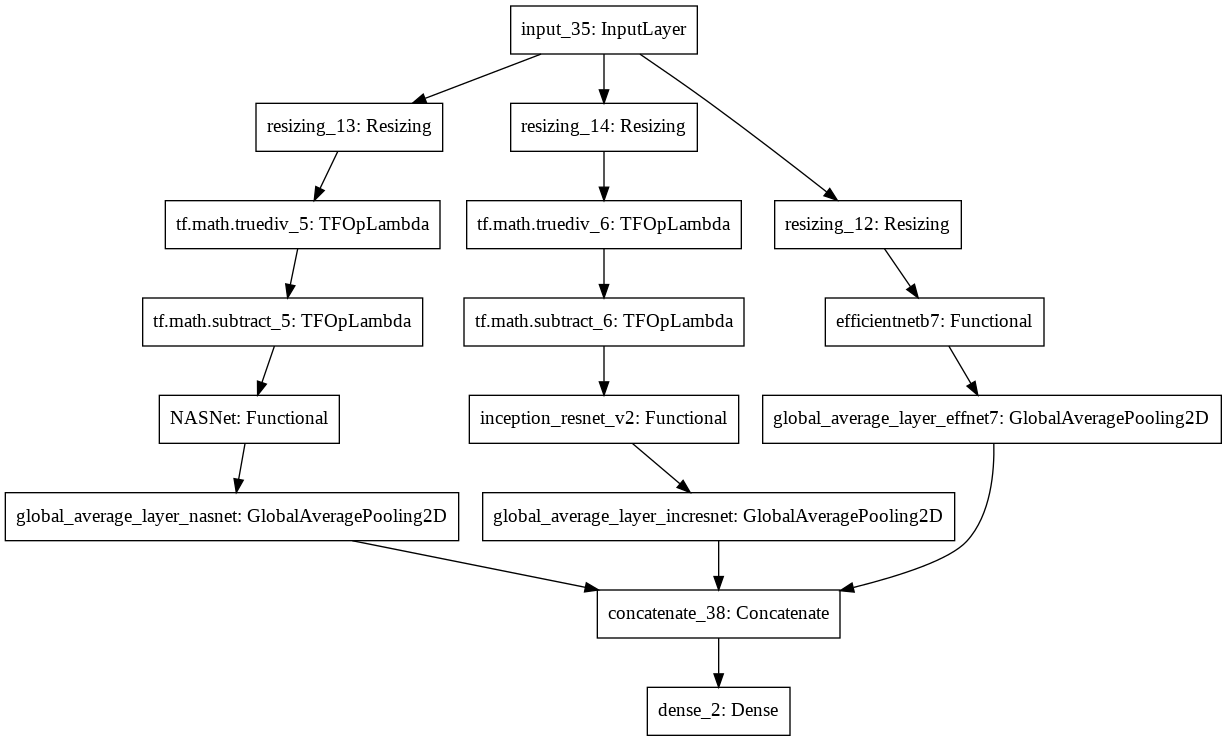

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(concatenate_model)

Es normal que el input de efficient net no haga nada, ya que este modelo pre entrenado no necesita mucha operacion, esto puede desprenderse de la documentación:
> This method does nothing and only kept as a placeholder to align the API surface between old and new version of model.

[preprocess input effnet documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/preprocess_input)

In [ ]:
concatenate_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
concatenate_model.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      # Add TensorBoard callback to model (callbacks parameter takes a list)
                      callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                            experiment_name="Concatenate Arquitecture")])

Saving TensorBoard log files to: tensorflow_hub/Concatenate Arquitecture/20210605-004035


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
269/269 [==============================] - 3385s 12s/step - loss: 0.5225 - accuracy: 0.8838 - val_loss: 0.2647 - val_accuracy: 0.9274
Epoch 2/5
269/269 [==============================] - 1399s 5s/step - loss: 0.1281 - accuracy: 0.9578 - val_loss: 0.2674 - val_accuracy: 0.9231
Epoch 3/5
269/269 [==============================] - 1399s 5s/step - loss: 0.0793 - accuracy: 0.9727 - val_loss: 0.2627 - val_accuracy: 0.9303
Epoch 4/5
269/269 [==============================] - 1398s 5s/step - loss: 0.0571 - accuracy: 0.9814 - val_loss: 0.2875 - val_accuracy: 0.9265
Epoch 5/5
269/269 [==============================] - 1399s 5s/step - loss: 0.0406 - accuracy: 0.9877 - val_loss: 0.2709 - val_accuracy: 0.9355


In [ ]:
concatenate_model.evaluate(test_data)

66/66 [==============================] - 272s 4s/step - loss: 0.2709 - accuracy: 0.9355


[0.27093568444252014, 0.9354838728904724]

No es mejor que efficientNet7, pero puede que generalice mejor asi que lo guardaremos.

In [ ]:
concatenate_model.save('concatenate_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
zip_folder('tensorflow_hub')

Lo que haremos ahora, será primero hacer un pequeño fine tuning de este nuevo modelo, el lado negativo es que toma mucho tiempo ejecutar cada epoch, pero el tiempo puede valer la pena, hasta ahora el mejor resultado que tenemos es EfficientNet7 con un 95%. Intentemos superar esto.

**Ideas**
- Fine Tuning
- Data Augmentation
- Callbacks
- Optimizadores 
- Revisar Shuffle = True

Si no mejoramos el 95%, habremos aprendido a hacer muchas cosas, y podemos intentar:

- Fine Tuning EfficentNet7
- Data Agumentation EfficientNet7
- etc...

## Fine Tune

In [ ]:
# Este modelo ya lo entrenamos
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Data/Proyecto buscomiperro/modelos/concatenate_model.h5')

In [ ]:
# Veamos cuantos parametros se estan entrenando por ahora
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
resizing_1 (Resizing)           (None, 331, 331, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
resizing_2 (Resizing)           (None, 299, 299, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 331, 331, 3)  0           resizing_1[0][0]                 
______________________________________________________________________________________________

In [ ]:
from keras.utils.layer_utils import count_params
p = count_params(model.trainable_weights)
print(f"Se entrenaron {p} parámetros")

Se entrenaron 1016125 parámetros


Hay que descongelar los pesos de cada modelo, veamos cuantos layers tiene cada uno

In [ ]:
efficient_layer = model.layers[8]
nasnet_layer = model.layers[9]
incresnet_layer = model.layers[10]

In [ ]:
print(f"EfficientNet7 tiene {len(efficient_layer.layers)} layers")
print(f"NasNet Large tiene {len(nasnet_layer.layers)} layers")
print(f"Inception ResNet tiene {len(incresnet_layer.layers)} layers")

EfficientNet7 tiene 813 layers
NasNet Large tiene 1039 layers
Inception ResNet tiene 780 layers


Hay que tener en cuenta que las capas superiores son las que extraen patrones más complejos, por lo que lo ideal seria descongelar estas. Voy a intentar descongelar el 10% superior de cada modelo

In [ ]:
# Antes veamos que no se esten entrenando parametros en estos modelos pre entrenados
print(efficient_layer.trainable_weights)
print(nasnet_layer.trainable_weights)
print(incresnet_layer.trainable_weights)

[]
[]
[]


In [ ]:
def unfreeze_layers(functional_layer, p):
  """"
  Función que descongela las últimas p porciento de las capas

  Args:
  functional_layer : modelo pre entrenado
  p : porcentaje a descongelar

  Return:
  None
  """

 

  # Descongelamos todas
  functional_layer.trainable = True
  num_trainable_layers = int(p*(len(functional_layer.layers)))

  
  #Freezeamos todas menos las ultimas p% capas
  for layer in functional_layer.layers[:-num_trainable_layers]:
    layer.trainable = False

  count = 0
  # Veamos ahora cuantas descongelamos
  for layer in functional_layer.layers:
    if layer.trainable == True:
      count += 1

  print(f"se han descongelado {count} layers")
  

  


In [ ]:
unfreeze_layers(efficient_layer, 0.1)

se han descongelado 81 layers


In [ ]:
unfreeze_layers(nasnet_layer, 0.1)

se han descongelado 103 layers


In [ ]:
unfreeze_layers(incresnet_layer, 0.1)

se han descongelado 78 layers


In [ ]:
# Aseguremonos de que haya surtido efecto en el modelo general
count_params(model.trainable_weights)

60213469

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
resizing_1 (Resizing)           (None, 331, 331, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
resizing_2 (Resizing)           (None, 299, 299, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 331, 331, 3)  0           resizing_1[0][0]                 
______________________________________________________________________________________________

FIUUUU, tendremos que ajustar aproximadamente 59 millones más de parámetros!!!!

Vamos a intentar fitear este modelo, si se demora mucho, tendremos que optar por simplemente tunear EfficientNet7. 
Recordar que Keras salva modelos inspeccionando sus arquitecturas. Esta técnica lo salva todo:

- Los valores de peso
- La arquitectura del modelo
- La configuración de entrenamiento del modelo (lo que pasa al método .compile() )
- El optimizador y su estado, si lo hay (esto le permite reiniciar el entrenamiento donde lo dejó)

Por lo que solo tenemos que hacer el `model.fit()`

In [ ]:
model.fit(train_data,
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/5
269/269 [==============================] - 2512s 9s/step - loss: 0.0352 - accuracy: 0.9893 - val_loss: 0.2868 - val_accuracy: 0.9279
Epoch 2/5
269/269 [==============================] - 1310s 5s/step - loss: 0.0305 - accuracy: 0.9896 - val_loss: 0.3025 - val_accuracy: 0.9307
Epoch 3/5
 10/269 [>.............................] - ETA: 17:14 - loss: 0.0250 - accuracy: 0.9875

KeyboardInterrupt: ignored

# Conclusión : 
En cuanto a performance y tiempo, conviene más hacer fine tuning al modelo pre entrenado EfficientNet. Eso lo realizaré en el notebook `BPM_ModelV2.py` 